## Goal:
- Build a Basic Langgraph Agent

#### imports

In [1]:
from typing import TypedDict, Annotated, Sequence
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool

from IPython.display import Image, display

import os
from dotenv import load_dotenv

In [ ]:
pip install setuptools

ERROR: Could not find a version that satisfies the requirement pkg_resources (from versions: none)
ERROR: No matching distribution found for pkg_resources
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pkg_resources
print(pkg_resources.get_distribution("langgraph").version)

ModuleNotFoundError: No module named 'pkg_resources'

In [3]:
load_dotenv()

True

#### AgentState

- 👉 `add_messages`: Whenever a new message is added to the state, don’t overwrite "messages". Instead, append it to the existing list.
- 👉 `Sequence`: Type hint: "messages" is a sequence (list, tuple, etc.) of `BaseMessage` objects.
- 👉 `BaseMessage`: can be `HumanMessage`, `AIMessage`, `SystemMessage`, `ToolMessage`

In [8]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

#### Define tools

In [9]:
@tool
def add(a:int, b:int):
    """ This is an addition function that adds two numbers"""
    return a + b

@tool
def sub(a:int, b:int):
    """ This is a subtraction function that subtracts two numbers"""
    return a - b

@tool
def multiply(a: int, b: int) -> int:
    """This is a multiplication function that multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

In [10]:
tools = [add, sub, multiply]

#### Define Model

In [11]:
llm = ChatOpenAI(
    model="/gpfs/projects/bsc02/llm_models/huggingface_models/Qwen3-32B",
    openai_api_key="dummy",  # vLLM doesn't need a real key
    openai_api_base="http://localhost:8002/v1",  # Your forwarded port
    temperature=0.7,
    max_tokens=500
)

In [20]:
model = llm.bind_tools(tools, tool_choice="none")

In [21]:
def model_call(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content="You are my AI assistant, please answer my query to the best of your ability.")
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

In [22]:
'''
'tool_calls': 
[{'id': 'call_yZ97kMZuNXrgpn7w1jOJwjRW', 
  'function': {'arguments': 
							'{"a":40,"b":12}', 
							'name': 'add'}, 
							'type': 'function'
			  }
]
'''
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1] ## Extracting the last AIMessage
    if not last_message.tool_calls:  
        return "end"
    else:
        return "continue"    

#### Building Graph

In [23]:
graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)
tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)
graph.set_entry_point("our_agent")
graph.add_conditional_edges("our_agent",
                            should_continue,
                            {
                                "continue": "tools",
                                "end": END
                            })
graph.add_edge("tools", "our_agent")
app = graph.compile()

#### Graph Visualization

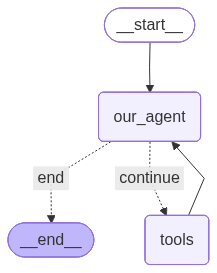

In [24]:
display(Image(app.get_graph().draw_mermaid_png()))

In [25]:
'''
param: stream is an iterator returned by app.stream(). 
So stream is not a list — it’s something you can iterate over (like reading a file line-by-line).
'''
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

#### Giving human input

In [26]:
'''
[("user", "Add 40 + 12")]

This means:
It’s a list with one message (the user’s message).
Each message tuple has two parts:
    The role — "user" (or "system", "assistant", "tool", etc.)
    The content — the text of the message ("Add 40 + 12")
'''
inputs = {"messages" : [("user", "Add 40 + 12")]}

In [27]:
print_stream(app.stream(input=inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12
================================== Ai Message ==================================

<think>
Okay, the user wants to add 40 and 12. Let me check the available functions. There's an 'add' function that takes two integers. The parameters are a and b, both required. So I need to call add with a=40 and b=12. That should give the correct result. No other functions are needed here. Let me make sure the syntax is right.
</think>

<tool_call>
{"name": "add", "arguments": {"a": 40, "b": 12}}
</tool_call>


In [28]:
inputs2 = {"messages" : [("user", "Multiply that by 2.")]}
print_stream(app.stream(input=inputs2, stream_mode="values"))

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

<think>
Okay, let's see. The user says "Multiply that by 2." Hmm, but I need to figure out what "that" refers to. The previous conversation might have mentioned a number, but since I don't have context, maybe I should ask for clarification. Wait, the tools available are add, subtract, and multiply. All require two integers. If "that" is a single number, I need to know which one they're referring to. Maybe they meant a previous result? But without context, I can't assume. I should probably ask the user to specify the numbers they want to multiply. Alternatively, if they meant a specific value from earlier, but since I don't have memory of past interactions, I need to prompt them for the necessary details. So the best move is to request clarification on what exactly they want multiplied by 2.
</think>

To p

**Note**: `No memory`